#  XPCS   Pipeline 

Get the data from databroker

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE
# register the fancy lazy chx eiger handler
# from chxtools import handlers

### Lazy Eiger Handler (later will goto databroker)

In [2]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

### Get the events from the uid

In [15]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

f = h5py.File('/XF11ID/data/2015/10/16/bcdd8b95-6adc-476b-9c65_25_master.h5','r')
#f.visititems(print_attrs)

In [4]:
hdr = db['e59f5']

In [5]:
list(hdr.keys())

['descriptors', 'start', 'stop']

In [10]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'])

hdf5 path = /XF11ID/data/2015/10/16/bcdd8b95-6adc-476b-9c65_25_master.h5


In [11]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']

In [12]:
imgs

<Frames>
Length: 3000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [13]:
imgs.md

{'beam_center_x': 0.0,
 'beam_center_y': 0.0,
 'count_time': 0.0039962204,
 'detector_distance': 1000.0,
 'frame_time': 0.0040000002,
 'framerate': 249.99998812563774,
 'incident_wavelength': 1.3811316,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

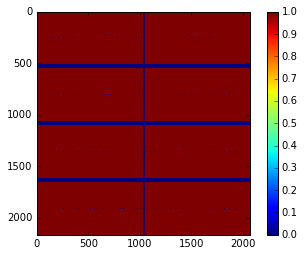

In [16]:
%matplotlib inline

plt.figure()
plt.imshow(imgs.md['pixel_mask'])
plt.colorbar()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

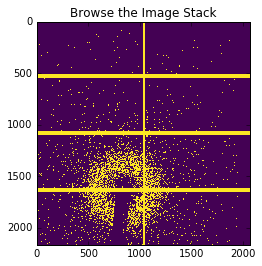

<function __main__.view_image>

In [17]:
%matplotlib inline
from ipywidgets import interact

def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 200))

In [18]:
#hey, let's see if any images are bad!
imgsum = [np.sum(img*imgs.md['pixel_mask']) for img in imgs[::25]]

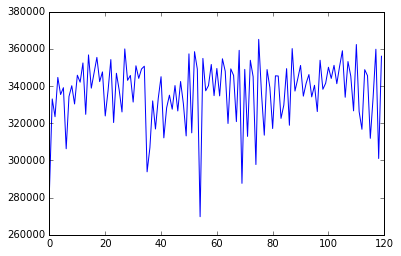

In [19]:
%matplotlib inline
plt.plot(imgsum)

### Get the Averaged Image Data

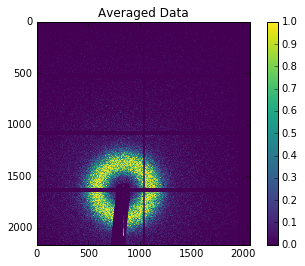

In [20]:
avg_img = np.average(imgs[::100], axis=0) * imgs.md['pixel_mask']
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img, vmin=0, vmax=1e0, cmap='viridis')
fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

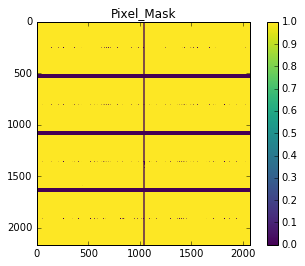

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(imgs.md['pixel_mask'], vmin=0, vmax=1e0, cmap='viridis')
fig.colorbar(im)
ax.set_title("Pixel_Mask")
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [22]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as utils

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Note:  Enter the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [23]:
imgs.md

{'beam_center_x': 0.0,
 'beam_center_y': 0.0,
 'count_time': 0.0039962204,
 'detector_distance': 1000.0,
 'frame_time': 0.0040000002,
 'framerate': 249.99998812563774,
 'incident_wavelength': 1.3811316,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [24]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Create the mask file

More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

In [31]:
%matplotlib notebook

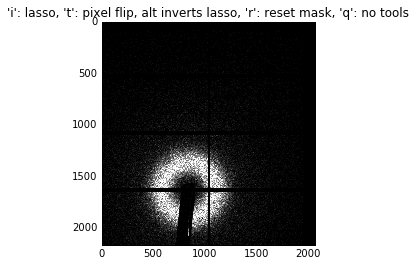

In [30]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img, vmin=0, vmax=1e0)

In [27]:
#np.save('mask_test', new_mask)
new_mask = np.load('mask_test.npy')

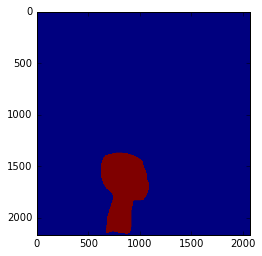

In [33]:

%matplotlib inline

#new_mask = m.mask
m.mask = new_mask
plt.imshow(new_mask)
plt.show()

### Combine the hand-drawn mask and the pixel mask

In [34]:
mask = ~m.mask * imgs.md['pixel_mask']

In [35]:
%matplotlib inline

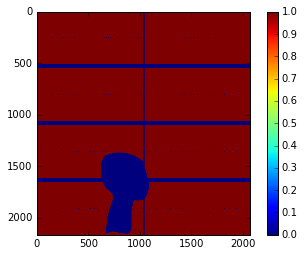

In [36]:
plt.figure()
plt.imshow(mask)
plt.colorbar()

## Get the approximate center and see the statistic to make sure 

In [37]:
center = (1634.66, 838.6)  # center of the speckle pattern
# center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [38]:
bin_centers, ring_averages= roi.circular_average(avg_img*mask, center, threshold=0, nx=1000,
                                         pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

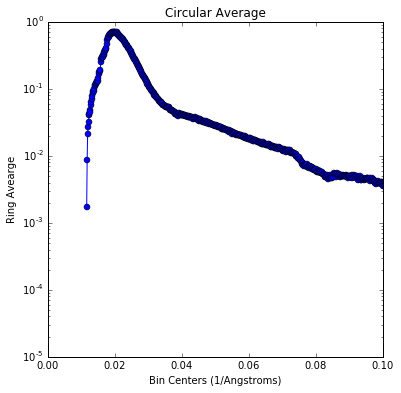

In [39]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
plt.show()

## Create label array (Q rings)

In [40]:
inner_radius = 210# radius of the first ring
width = 15        # width of each ring
spacing = 2      # no spacing between rings
num_rings = 15   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 210.,  225.],
       [ 227.,  242.],
       [ 244.,  259.],
       [ 261.,  276.],
       [ 278.,  293.],
       [ 295.,  310.],
       [ 312.,  327.],
       [ 329.,  344.],
       [ 346.,  361.],
       [ 363.,  378.],
       [ 380.,  395.],
       [ 397.,  412.],
       [ 414.,  429.],
       [ 431.,  446.],
       [ 448.,  463.]])

In [41]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_val

array([[ 0.01433025,  0.01535383],
       [ 0.01549031,  0.01651389],
       [ 0.01665036,  0.01767394],
       [ 0.01781042,  0.01883399],
       [ 0.01897047,  0.01999404],
       [ 0.02013052,  0.02115408],
       [ 0.02129056,  0.02231413],
       [ 0.0224506 ,  0.02347417],
       [ 0.02361064,  0.0246342 ],
       [ 0.02477068,  0.02579423],
       [ 0.02593071,  0.02695426],
       [ 0.02709074,  0.02811429],
       [ 0.02825076,  0.02927431],
       [ 0.02941078,  0.03043432],
       [ 0.03057079,  0.03159433]])

In [42]:
q_ring_center = np.array( [(q_ring_val[i][0] + q_ring_val[i][1])/2 for 
                           i in range(num_rings)])
q_ring_center

array([ 0.01484204,  0.0160021 ,  0.01716215,  0.0183222 ,  0.01948225,
        0.0206423 ,  0.02180234,  0.02296238,  0.02412242,  0.02528246,
        0.02644249,  0.02760251,  0.02876253,  0.02992255,  0.03108256])

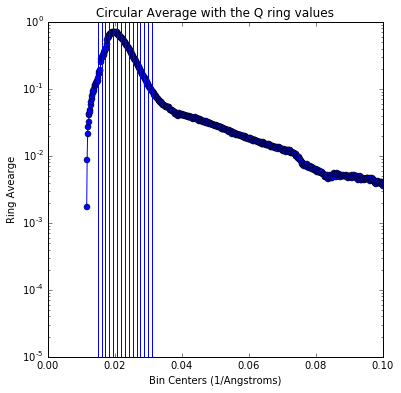

In [43]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average with the Q ring values")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
for i in range(num_rings):
    #axes.axvline(q_ring_val[i, 0])
    axes.axvline(q_ring_center[i])
plt.show()

In [44]:
center

(1634.66, 838.6)

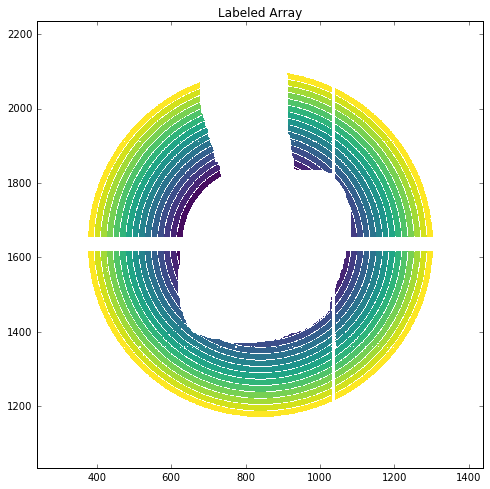

In [47]:
%matplotlib inline
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask
#% matplotlib notebook
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 600 
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])
plt.show()

## Plot Kymograph (Waterfall plot) for a vertical and hortizontal cuts


Note : Give coordinates of the upper-left corner and width and height of each
rectangle: e.g., [(x, y, w, h), (x, y, w, h)]


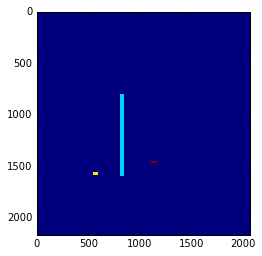

In [57]:
vert_rect = ((800, 803,800, 40), (1554, 546, 30, 40), (1454, 1098, 20, 60)) 

V_K_label_array = roi.rectangles(vert_rect, avg_img.shape)
plt.figure()
plt.imshow(V_K_label_array)
plt.show()

In [58]:
V_K_label_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##  Kymograph(waterfall plot) of the 3rd ring

In [50]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [50]:
masker = Masker(imgs, mask)

In [63]:
veri_kymo = roi.kymograph(masker, V_K_label_array*mask, num = 1)

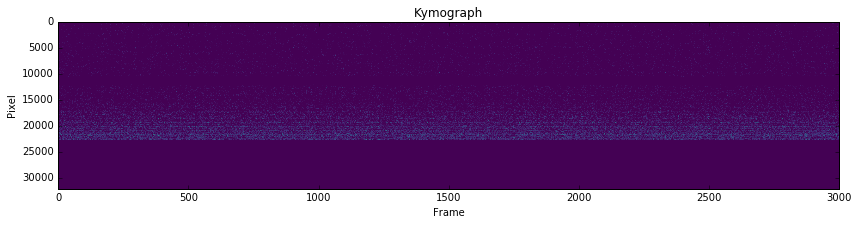

In [79]:

fig, ax = plt.subplots(figsize=(14,10))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(veri_kymo.T, cmap='viridis', vmax=10)
#fig.colorbar( im   )
ax.set_aspect(0.02)
plt.show()

##  Mean intensities for each ring

In [80]:
mask_data = masker[::50]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [82]:
mean_int_sets.shape

(60, 15)

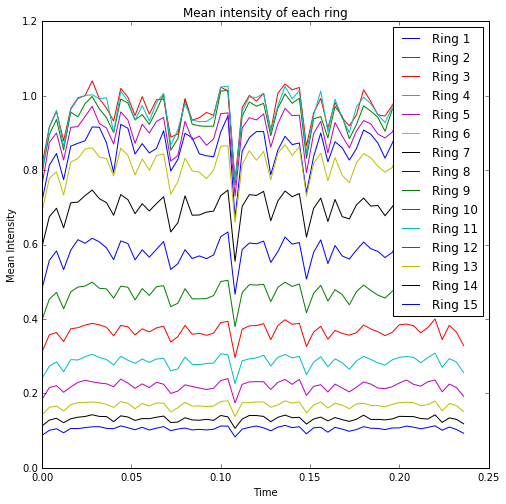

In [83]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## Extract the labeled array

In [105]:
labels, indices = roi.extract_label_indices(ring_mask)

In [108]:
nopr  = np.array( [ len(np.where(labels==i)[0]) for i in range( 1, num_rings+1) ] )
nopr

array([ 3392,  6433,  9768, 16882, 20774, 23645, 25285, 26844, 28416,
       29917, 31456, 33046, 34556, 36206, 37836])

In [85]:
subset = imgs[:100]

Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
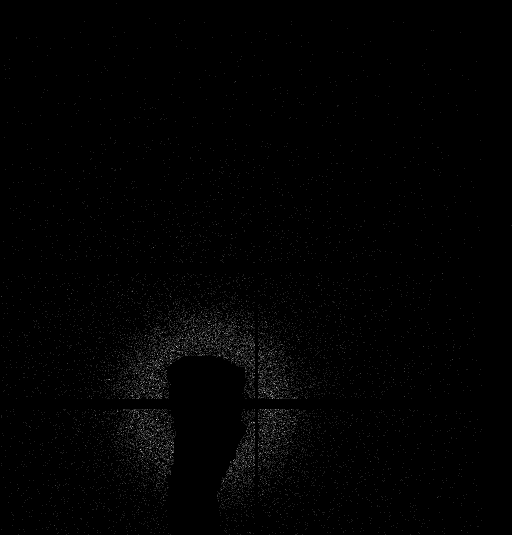

In [95]:
masker[1000]

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [110]:
num_lev = 9  
num_buf = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf, ring_mask,
                                           imgs)

In [52]:
%matplotlib inline

### Plot the one time correlation functions

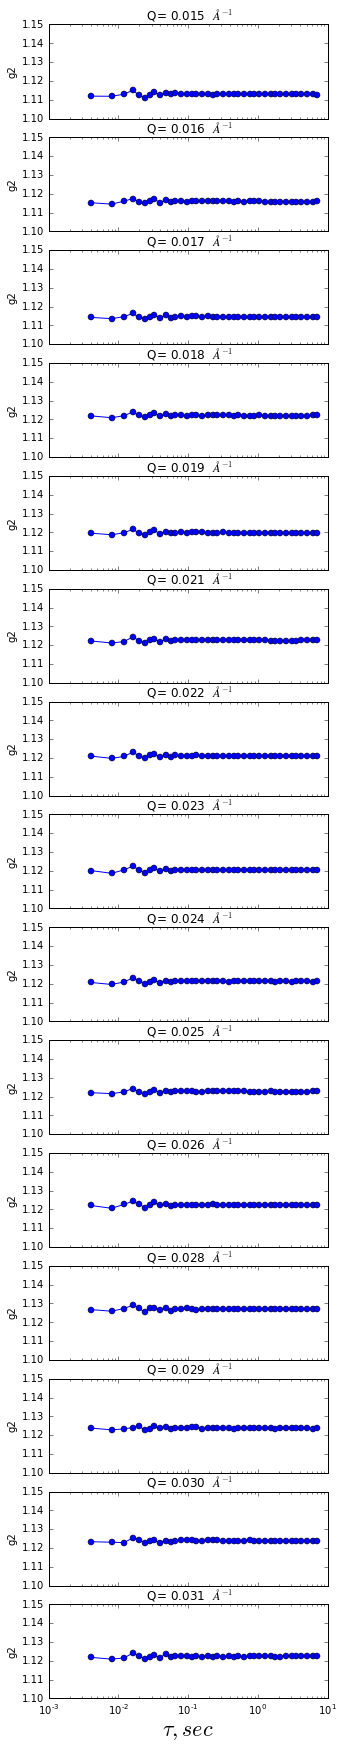

In [126]:
lags = lag_steps*timeperframe

fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5, 30))
axes[num_rings-1].set_xlabel(r"$\tau,sec$", fontsize=22)
for i in range(num_rings):
    axes[i].set_ylabel("g2") 
    axes[i].set_title(" Q= " + '%.3f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    axes[i].semilogx(lags, g2[:, i], '-o', markersize=6)
    axes[i].set_ylim(bottom=1.10, top=1.15)
plt.show()